In [237]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
import sklearn as sk
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import optuna
import xgboost as xgb

In [2]:
crime_df = pd.read_csv("../data/clean_crime_df.csv")
staff_df = pd.read_csv("../data/clean_staff_df.csv")


In [3]:
crime_df.head()

,Call Date,call_time,District,Sector,Call Type,year,month,day,call_hour,month_day,priority,month_num
0,2020-01-01,00:05:46,2,21,UNKNOWN TROUBLE,2020,Jan,1,0,Jan-01,high,1
1,2020-01-01,02:06:01,4,44,ASSAULT IN PROGRESS,2020,Jan,1,2,Jan-01,high,1
2,2020-01-01,00:37:32,5,55,FIRE,2020,Jan,1,0,Jan-01,high,1
3,2020-01-01,01:41:30,5,55,CHECK WELFARE,2020,Jan,1,1,Jan-01,medium,1
4,2020-01-01,00:46:26,1,13,DOMESTIC VIOLENCE,2020,Jan,1,0,Jan-01,high,1


In [4]:
staff_df.head()

,Platoon,Officer Badge #,Exception Date,Exception Start Time,# of Hours,Exception Type,year,month,day,month_day,hour
0,4 District B Platoon,34260,2020-02-27,07:00:00,12.0,Vacation,2020,Feb,27,Feb-27,7
1,4 District B Platoon,34260,2020-02-20,07:00:00,10.0,Training,2020,Feb,20,Feb-20,7
2,4 District B Platoon,34260,2020-02-19,07:00:00,10.0,Training,2020,Feb,19,Feb-19,7
3,4 District B Platoon,34260,2020-03-07,07:00:00,12.0,Sick,2020,Mar,7,Mar-07,7
4,4 District B Platoon,34260,2020-02-28,07:00:00,12.0,Vacation,2020,Feb,28,Feb-28,7


In [16]:
staff_df['Exception Start Time'].unique()

array(['07:00:00', '19:00:00', '17:00:00', '05:00:00', '08:00:00',
       '12:30:00', '15:00:00', '21:00:00', '18:00:00', '06:00:00',
       '22:00:00', '14:00:00', '13:00:00', '12:00:00', '00:00:00',
       '02:00:00', '01:00:00', '04:00:00', '03:00:00', '16:00:00',
       '11:00:00', '08:30:00', '09:00:00', '09:30:00', '21:30:00',
       '23:00:00', '15:30:00', '16:30:00', '03:30:00', '01:30:00',
       '04:30:00', '13:30:00', '21:45:00', '00:30:00', '20:00:00',
       '17:30:00', '22:30:00', '14:30:00', '10:00:00', '10:45:00',
       '19:30:00', '11:30:00', '07:30:00', '23:30:00', '18:30:00',
       '05:30:00', '00:45:00', '02:30:00', '20:30:00', '09:15:00',
       '16:45:00', '06:30:00', '18:45:00', '16:15:00', '03:45:00',
       '01:45:00'], dtype=object)

In [21]:
'07:30:0' < '07:00:00'

False

In [292]:
def shifts(x):
    
    if x < 7:
        return 'night shift'
    elif x <  15:
        return 'day shift'
    elif x < 23 :
        return 'evening shift'
    else:
        return 'night shift'

In [23]:
staff_df['shift'] = staff_df['Exception Start Time'].apply(shifts)
staff_df

,Platoon,Officer Badge #,Exception Date,Exception Start Time,# of Hours,Exception Type,year,month,day,month_day,hour,shift
0,4 District B Platoon,34260,2020-02-27,07:00:00,12.0,Vacation,2020,Feb,27,Feb-27,7,day
1,4 District B Platoon,34260,2020-02-20,07:00:00,10.0,Training,2020,Feb,20,Feb-20,7,day
2,4 District B Platoon,34260,2020-02-19,07:00:00,10.0,Training,2020,Feb,19,Feb-19,7,day
3,4 District B Platoon,34260,2020-03-07,07:00:00,12.0,Sick,2020,Mar,7,Mar-07,7,day
4,4 District B Platoon,34260,2020-02-28,07:00:00,12.0,Vacation,2020,Feb,28,Feb-28,7,day
...,...,...,...,...,...,...,...,...,...,...,...,...
28369,4 District C Platoon,38160,2022-12-22,18:00:00,12.0,Sick,2022,Dec,22,Dec-22,18,evening
28370,4 District D Platoon,37350,2022-12-22,07:00:00,12.0,Vacation,2022,Dec,22,Dec-22,7,day
28371,4 District D Platoon,37350,2022-12-30,07:00:00,6.0,Vacation,2022,Dec,30,Dec-30,7,day
28372,4 District D Platoon,37350,2022-12-31,19:00:00,12.0,Vacation,2022,Dec,31,Dec-31,19,evening


In [28]:
# seasonality
def seasonality(date):
    """
    Return the season given the date.

    date: Exception date 
    
    date thresholds are referenced from
    https://www.timeanddate.com/calendar/seasons.html
    """
    date = str(date)
    if date < "2020-03-19":
        return "winter"
    
    elif date < "2020-06-20":
        return "spring"
    
    elif date < "2020-09-22":
        return "summer"
    
    elif date < "2020-12-21":
        return "fall"
    
    elif date < "2021-03-20":
        return "winter"
    
    elif date < "2021-06-20":
        return "spring"
    
    elif date < "2021-09-22":
        return "summer"
    
    elif date < "2021-12-21":
        return "fall"
    
    elif date < "2022-03-20":
        return "winter"
    
    elif date < "2022-06-21":
        return "spring"
    
    elif date < "2022-09-22":
        return "summer"
    
    elif date < "2022-12-21":
        return "fall"
    
    else:
        return "winter"
    

staff_df['season'] = staff_df['Exception Date'].apply(seasonality)

staff_df.head()

,Platoon,Officer Badge #,Exception Date,Exception Start Time,# of Hours,Exception Type,year,month,day,month_day,hour,shift,season
0,4 District B Platoon,34260,2020-02-27,07:00:00,12.0,Vacation,2020,Feb,27,Feb-27,7,day,winter
1,4 District B Platoon,34260,2020-02-20,07:00:00,10.0,Training,2020,Feb,20,Feb-20,7,day,winter
2,4 District B Platoon,34260,2020-02-19,07:00:00,10.0,Training,2020,Feb,19,Feb-19,7,day,winter
3,4 District B Platoon,34260,2020-03-07,07:00:00,12.0,Sick,2020,Mar,7,Mar-07,7,day,winter
4,4 District B Platoon,34260,2020-02-28,07:00:00,12.0,Vacation,2020,Feb,28,Feb-28,7,day,winter


In [39]:
staff_df['month_num'] = staff_df['Exception Date'].apply(lambda x: x[5:7]).apply(int)

In [40]:
staff_df

,Platoon,Officer Badge #,Exception Date,Exception Start Time,# of Hours,Exception Type,year,month,day,month_day,hour,shift,season,month_num
0,4 District B Platoon,34260,2020-02-27,07:00:00,12.0,Vacation,2020,Feb,27,Feb-27,7,day,winter,2
1,4 District B Platoon,34260,2020-02-20,07:00:00,10.0,Training,2020,Feb,20,Feb-20,7,day,winter,2
2,4 District B Platoon,34260,2020-02-19,07:00:00,10.0,Training,2020,Feb,19,Feb-19,7,day,winter,2
3,4 District B Platoon,34260,2020-03-07,07:00:00,12.0,Sick,2020,Mar,7,Mar-07,7,day,winter,3
4,4 District B Platoon,34260,2020-02-28,07:00:00,12.0,Vacation,2020,Feb,28,Feb-28,7,day,winter,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28369,4 District C Platoon,38160,2022-12-22,18:00:00,12.0,Sick,2022,Dec,22,Dec-22,18,evening,winter,12
28370,4 District D Platoon,37350,2022-12-22,07:00:00,12.0,Vacation,2022,Dec,22,Dec-22,7,day,winter,12
28371,4 District D Platoon,37350,2022-12-30,07:00:00,6.0,Vacation,2022,Dec,30,Dec-30,7,day,winter,12
28372,4 District D Platoon,37350,2022-12-31,19:00:00,12.0,Vacation,2022,Dec,31,Dec-31,19,evening,winter,12


In [82]:
staff_df['Exception Type'].value_counts() /staff_df.shape[0]

Exception Type
Vacation    0.631917
Training    0.224149
Sick        0.143935
Name: count, dtype: float64

In [216]:
cat_preds = staff_df[['shift','season']]
num_preds = staff_df[['# of Hours', 'month_num','day','hour']]

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(cat_preds)

# get label y values
label_encoder = LabelEncoder()


label_encoder.fit(staff_df['Exception Type'])

LabelEncoder()

In [238]:
X

,# of Hours,month_num,day,hour,shift,season
0,12.0,2,27,7,day,winter
1,10.0,2,20,7,day,winter
2,10.0,2,19,7,day,winter
3,12.0,3,7,7,day,winter
4,12.0,2,28,7,day,winter
...,...,...,...,...,...,...
28369,12.0,12,22,18,evening,winter
28370,12.0,12,22,7,day,winter
28371,6.0,12,30,7,day,winter
28372,12.0,12,31,19,evening,winter


In [171]:
X = staff_df[['# of Hours', 'month_num','day','hour','shift','season']]
Y_unlabeled= staff_df['Exception Type']

In [194]:
# train test split
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y_unlabeled, 
                                                                    random_state=888, 
                                                                    test_size=0.20)


# make sure indexes are correct
train_df = pd.concat([x_train,y_train],axis=1)


# over sample

n = 2000

extra_sick = train_df[
        train_df['Exception Type'] == 'Sick'
        ].sample(n, random_state= 888)


train_over_sample = pd.concat([train_df, extra_sick], axis=0)
train_over_sample


# training
x_train = train_over_sample[['# of Hours', 'month_num',
                   'day','hour','shift','season']]
y_train = train_over_sample['Exception Type']

cat_preds = x_train[['shift','season']]
num_preds = x_train[['# of Hours', 'month_num','day','hour']]

cat_preads = enc.transform(cat_preds).toarray()
cat_preds = pd.DataFrame(cat_preds, index = num_preds.index)
x_train = pd.concat([num_preds,cat_preds],axis=1)


y_train = pd.DataFrame(label_encoder.transform(y_train))


# testing
cat_preds = x_test[['shift','season']]
num_preds = x_test[['# of Hours', 'month_num','day','hour']]

cat_preds = enc.transform(cat_preds).toarray()
cat_preds = pd.DataFrame(cat_preds, index = num_preds.index)
x_test = pd.concat([num_preds,cat_preds],axis=1)

y_test = pd.DataFrame(label_encoder.transform(y_test))


In [241]:
#Start of gradient boosted tree

xgb_model = xgb.XGBClassifier(n_estimators=10000) # initialize tree

xgb_model.fit(x_train, np.ravel(y_train)) # train tree

predict_xgb = xgb_model.predict_proba(x_test) # 1st col = pred val, 2nd col = pred prob

predict_xgb_prob = pd.DataFrame(predict_xgb,columns = ['Sick','Training', 'Vacation'])

prob_preds = pd.concat([predict_xgb_prob, y_test.reset_index(drop=True)],axis=1)

prob_preds['y_pred'] = prob_preds.apply(find_max_and_assign,axis=1)


print(classification_report(prob_preds[0], prob_preds['y_pred']))

              precision    recall  f1-score   support

           0       0.38      0.25      0.30       841
           1       0.95      0.96      0.96      1279
           2       0.83      0.90      0.86      3555

    accuracy                           0.81      5675
   macro avg       0.72      0.70      0.71      5675
weighted avg       0.79      0.81      0.80      5675



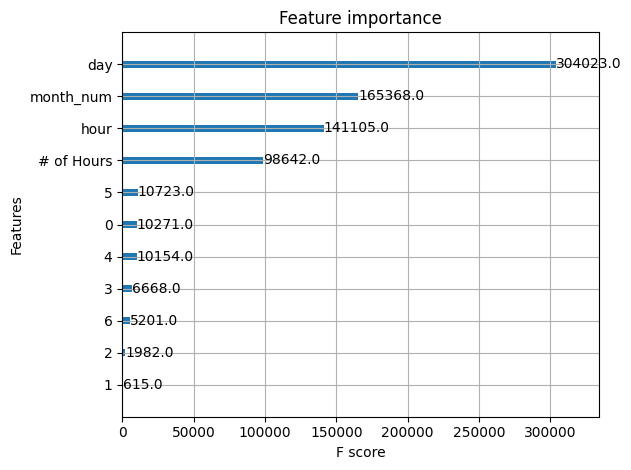

In [242]:
plot_importance(xgb_model)
plt.tight_layout()

In [227]:
predict_xgb = xgb_model.predict_proba(x_test) # 1st col = pred val, 2nd col = pred prob

predict_xgb_prob = pd.DataFrame(predict_xgb,columns = ['Sick','Training', 'Vacation'])

prob_preds = pd.concat([predict_xgb_prob, y_test.reset_index(drop=True)],axis=1)

prob_preds['y_pred'] = prob_preds.apply(find_max_and_assign,axis=1)


print(classification_report(prob_preds[0], prob_preds['y_pred']))

              precision    recall  f1-score   support

           0       0.37      0.25      0.30       841
           1       0.95      0.96      0.95      1279
           2       0.83      0.89      0.86      3555

    accuracy                           0.81      5675
   macro avg       0.72      0.70      0.70      5675
weighted avg       0.79      0.81      0.80      5675



In [196]:
def find_max_and_assign(row):
    # Extract the values for 'Sick', 'Training', and 'Vacation'
    values = row[['Sick', 'Training', 'Vacation']]
    
    # Find the column with the maximum value
    max_col = values.idxmax()
    
    # Assign the new value to 'Predictions' based on the max column
    if max_col == 'Sick':
        return 0
    elif max_col == 'Training':
        return 1
    elif max_col == 'Vacation':
        return 2

In [234]:
report = classification_report(prob_preds[0], prob_preds['y_pred'], output_dict=True)

report['0']['recall']
report['1']['recall']
report['2']['recall']

0.8928270042194093

In [240]:
print(report['weighted avg'])

{'precision': 0.7895365048786614, 'recall': 0.81215859030837, 'f1-score': 0.7983806994706647, 'support': 5675}


In [215]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, show_progress_bar=True)


  0%|          | 0/20 [00:00<?, ?it/s]

1
[0]	validation_0-mlogloss:1.09456


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.53780
[1000]	validation_0-mlogloss:0.51154
[1500]	validation_0-mlogloss:0.50295
[2000]	validation_0-mlogloss:0.49775
[2500]	validation_0-mlogloss:0.49397
[3000]	validation_0-mlogloss:0.49115
[3500]	validation_0-mlogloss:0.48876
[3999]	validation_0-mlogloss:0.48676
1
[0]	validation_0-mlogloss:1.08681


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.50477
[1000]	validation_0-mlogloss:0.48934
[1499]	validation_0-mlogloss:0.48129
1
[0]	validation_0-mlogloss:1.08978


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.50986
[1000]	validation_0-mlogloss:0.49308
[1500]	validation_0-mlogloss:0.48547
[2000]	validation_0-mlogloss:0.48021
[2500]	validation_0-mlogloss:0.47616
[3000]	validation_0-mlogloss:0.47292
[3500]	validation_0-mlogloss:0.47011
[4000]	validation_0-mlogloss:0.46770
[4500]	validation_0-mlogloss:0.46559
[4999]	validation_0-mlogloss:0.46367
1
[0]	validation_0-mlogloss:1.08523


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.48678
[1000]	validation_0-mlogloss:0.47013
[1500]	validation_0-mlogloss:0.46093
[1999]	validation_0-mlogloss:0.45451
1
[0]	validation_0-mlogloss:1.08914


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.44929
[1000]	validation_0-mlogloss:0.42479
[1500]	validation_0-mlogloss:0.41334
[2000]	validation_0-mlogloss:0.40552
[2499]	validation_0-mlogloss:0.39950
1
[0]	validation_0-mlogloss:1.09385


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[499]	validation_0-mlogloss:0.57926
1
[0]	validation_0-mlogloss:1.09336


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.52442
[1000]	validation_0-mlogloss:0.49541
[1500]	validation_0-mlogloss:0.48536
[2000]	validation_0-mlogloss:0.47981
[2500]	validation_0-mlogloss:0.47573
[2999]	validation_0-mlogloss:0.47232
1
[0]	validation_0-mlogloss:1.08563


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[499]	validation_0-mlogloss:0.52042
1
[0]	validation_0-mlogloss:1.08832


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.51879
[1000]	validation_0-mlogloss:0.50333
[1500]	validation_0-mlogloss:0.49522
[2000]	validation_0-mlogloss:0.48961
[2500]	validation_0-mlogloss:0.48537
[3000]	validation_0-mlogloss:0.48187
[3500]	validation_0-mlogloss:0.47897
[3999]	validation_0-mlogloss:0.47644
1
[0]	validation_0-mlogloss:1.08595


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.50225
[1000]	validation_0-mlogloss:0.48739
[1500]	validation_0-mlogloss:0.47992
[2000]	validation_0-mlogloss:0.47466
[2500]	validation_0-mlogloss:0.47072
[3000]	validation_0-mlogloss:0.46737
[3500]	validation_0-mlogloss:0.46452
[4000]	validation_0-mlogloss:0.46193
[4500]	validation_0-mlogloss:0.45983
[4999]	validation_0-mlogloss:0.45781
1
[0]	validation_0-mlogloss:1.09465


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.54680
[1000]	validation_0-mlogloss:0.52256
[1500]	validation_0-mlogloss:0.51399
[2000]	validation_0-mlogloss:0.50864
[2500]	validation_0-mlogloss:0.50479
[3000]	validation_0-mlogloss:0.50195
[3499]	validation_0-mlogloss:0.49950
1


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.08808
[500]	validation_0-mlogloss:0.50629
[1000]	validation_0-mlogloss:0.49269
[1499]	validation_0-mlogloss:0.48583
1
[0]	validation_0-mlogloss:1.09133


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.51560
[1000]	validation_0-mlogloss:0.49508
[1499]	validation_0-mlogloss:0.48622
1
[0]	validation_0-mlogloss:1.08666


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.49800
[1000]	validation_0-mlogloss:0.48158
[1500]	validation_0-mlogloss:0.47282
[2000]	validation_0-mlogloss:0.46665
[2500]	validation_0-mlogloss:0.46181
[3000]	validation_0-mlogloss:0.45782
[3500]	validation_0-mlogloss:0.45444
[3999]	validation_0-mlogloss:0.45151
1
[0]	validation_0-mlogloss:1.09455


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.51921
[1000]	validation_0-mlogloss:0.48781
[1499]	validation_0-mlogloss:0.47695
1
[0]	validation_0-mlogloss:1.09329


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.56936
[1000]	validation_0-mlogloss:0.53753
[1500]	validation_0-mlogloss:0.52905
[2000]	validation_0-mlogloss:0.52467
[2500]	validation_0-mlogloss:0.52148
[3000]	validation_0-mlogloss:0.51887
[3500]	validation_0-mlogloss:0.51658
[3999]	validation_0-mlogloss:0.51461
1
[0]	validation_0-mlogloss:1.09518


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.55508
[1000]	validation_0-mlogloss:0.52606
[1500]	validation_0-mlogloss:0.51660
[2000]	validation_0-mlogloss:0.51072
[2500]	validation_0-mlogloss:0.50659
[2999]	validation_0-mlogloss:0.50361
1
[0]	validation_0-mlogloss:1.08402


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.50961
[1000]	validation_0-mlogloss:0.49513
[1500]	validation_0-mlogloss:0.48777
[2000]	validation_0-mlogloss:0.48266
[2499]	validation_0-mlogloss:0.47884
1
[0]	validation_0-mlogloss:1.09298


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.52522
[999]	validation_0-mlogloss:0.50134
1
[0]	validation_0-mlogloss:1.09256


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.51296
[1000]	validation_0-mlogloss:0.48213
[1500]	validation_0-mlogloss:0.47232
[2000]	validation_0-mlogloss:0.46623
[2500]	validation_0-mlogloss:0.46131
[3000]	validation_0-mlogloss:0.45723
[3500]	validation_0-mlogloss:0.45371
[4000]	validation_0-mlogloss:0.45041
[4499]	validation_0-mlogloss:0.44758


In [217]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best objective value:', study.best_value)

Number of finished trials: 20
Best trial: {'lambda': 0.5638673580858264, 'alpha': 0.00882913704049085, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 4000, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 166}
Best objective value: 0.6281676210211776


In [222]:
best_params = {'lambda': 0.5638673580858264, 'alpha': 0.00882913704049085, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 4000, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 166}

opt_model = xgb.XGBClassifier(**best_params)

opt_model.fit(x_train, np.ravel(y_train)) # train tree

predict_xgb = opt_model.predict_proba(x_test) # 1st col = pred val, 2nd col = pred prob

predict_xgb_prob = pd.DataFrame(predict_xgb,columns = ['Sick','Training', 'Vacation'])

prob_preds = pd.concat([predict_xgb_prob, y_test.reset_index(drop=True)],axis=1)

prob_preds['y_pred'] = prob_preds.apply(find_max_and_assign,axis=1)


print(classification_report(prob_preds[0], prob_preds['y_pred']))

              precision    recall  f1-score   support

           0       0.47      0.17      0.25       841
           1       0.93      0.96      0.95      1279
           2       0.82      0.94      0.88      3555

    accuracy                           0.83      5675
   macro avg       0.74      0.69      0.69      5675
weighted avg       0.80      0.83      0.80      5675



In [ ]:
pivot_table(values='call_time', index = 'call_hour', columns='year', aggfunc='sum')
year_hour_pivot.head()

In [251]:
staff_df['Exception Type'].str.split(', ')

0        [Vacation]
1        [Training]
2        [Training]
3            [Sick]
4        [Vacation]
            ...    
28369        [Sick]
28370    [Vacation]
28371    [Vacation]
28372    [Vacation]
28373    [Vacation]
Name: Exception Type, Length: 28374, dtype: object

In [255]:
staff_df.head()

,Platoon,Officer Badge #,Exception Date,Exception Start Time,# of Hours,Exception Type,year,month,day,month_day,hour,shift,season,month_num
0,4 District B Platoon,34260,2020-02-27,07:00:00,12.0,Vacation,2020,Feb,27,Feb-27,7,day,winter,2
1,4 District B Platoon,34260,2020-02-20,07:00:00,10.0,Training,2020,Feb,20,Feb-20,7,day,winter,2
2,4 District B Platoon,34260,2020-02-19,07:00:00,10.0,Training,2020,Feb,19,Feb-19,7,day,winter,2
3,4 District B Platoon,34260,2020-03-07,07:00:00,12.0,Sick,2020,Mar,7,Mar-07,7,day,winter,3
4,4 District B Platoon,34260,2020-02-28,07:00:00,12.0,Vacation,2020,Feb,28,Feb-28,7,day,winter,2


In [293]:
staff_df['shift']= staff_df['Exception Start Time'].apply(lambda x: shifts(int(x[:2])))
date_shift = staff_df.groupby(['Exception Date', 'shift']).count().reset_index()[['Exception Date', 'shift','Platoon']]
date_shift =date_shift.rename(columns={'Platoon':'shift_count'})
date_shift_pivot=date_shift.pivot_table(index='Exception Date', columns='shift', values='shift_count')
date_shift_pivot = date_shift_pivot.reset_index()
date_shift_pivot

shift,Exception Date,day shift,evening shift,night shift
0,2020-01-01,8.0,14.0,4.0
1,2020-01-02,7.0,9.0,2.0
2,2020-01-03,7.0,11.0,1.0
3,2020-01-04,2.0,7.0,1.0
4,2020-01-05,3.0,12.0,1.0
...,...,...,...,...
1091,2022-12-27,3.0,13.0,11.0
1092,2022-12-28,4.0,16.0,7.0
1093,2022-12-29,12.0,13.0,7.0
1094,2022-12-30,6.0,17.0,12.0


In [336]:
staff_df.columns

Index(['Platoon', 'Officer Badge #', 'Exception Date', 'Exception Start Time',
       '# of Hours', 'Exception Type', 'year', 'month', 'day', 'month_day',
       'hour', 'shift', 'season', 'month_num', 'call_hour'],
      dtype='object')

In [337]:
staff_df.pivot(index=['# of Hours', 'year', 'month', 'day', 'month_day',
       'hour', 'shift', 'season', 'month_num', 'call_hour'], 
               columns='Exception Type')

ValueError: Index contains duplicate entries, cannot reshape

In [340]:
staff_df['shift']= staff_df['Exception Start Time'].apply(lambda x: shifts(int(x[:2])))
staff_df['season'] = staff_df['Exception Date'].apply(seasonality)
staff_df['month'] = staff_df['Exception Date'].apply(lambda x: int(x[:5:7]))
staff_df['day'] = staff_df['Exception Date'].apply(lambda x: int(x[-2:]))
staff_df['call_hour'] = staff_df['Exception Start Time'].apply(lambda x: int(x[:2]))
staff_df.head()

,Platoon,Officer Badge #,Exception Date,Exception Start Time,# of Hours,Exception Type,year,month,day,month_day,hour,shift,season,month_num,call_hour
0,4 District B Platoon,34260,2020-02-27,07:00:00,12.0,Vacation,2020,2,27,Feb-27,7,day shift,winter,2,7
1,4 District B Platoon,34260,2020-02-20,07:00:00,10.0,Training,2020,2,20,Feb-20,7,day shift,winter,2,7
2,4 District B Platoon,34260,2020-02-19,07:00:00,10.0,Training,2020,2,19,Feb-19,7,day shift,winter,2,7
3,4 District B Platoon,34260,2020-03-07,07:00:00,12.0,Sick,2020,2,7,Mar-07,7,day shift,winter,3,7
4,4 District B Platoon,34260,2020-02-28,07:00:00,12.0,Vacation,2020,2,28,Feb-28,7,day shift,winter,2,7


In [345]:
df = staff_df.copy()
# Pivot table for 'Exception Type'
exception_pivot = df.pivot_table(index='Exception Date', columns='Exception Type', values='# of Hours', aggfunc='sum', fill_value=0)

# Pivot table for 'Shift'
shift_pivot = df.pivot_table(index='Exception Date', columns='shift', aggfunc='size', fill_value=0)

# Aggregate other necessary columns by 'Exception Date'
agg_df = df.groupby('Exception Date').agg({
    'month': 'first',
    'day': 'first',
    '# of Hours': 'sum',  # Summing the '# of Hours'
    'shift': pd.Series.nunique  # Counting distinct shift types
}).rename(columns={'shift': 'Number of Shift Types'})

# Merge the pivot tables with the aggregated DataFrame
final_df = pd.merge(agg_df, exception_pivot, left_on='Exception Date', right_index=True)
final_df = pd.merge(final_df, shift_pivot, left_on='Exception Date', right_index=True)


In [354]:
def replace_outliers(df, columns):
    
    for col in columns:

        # Calculate Q1 and Q3
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)

        # Calculate IQR
        IQR = Q3 - Q1

        # Define Outlier Thresholds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identifying outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        df[col] = df[col].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

    return df

In [355]:
print(final_df.columns)
final_df.head()

Index(['month', 'day', '# of Hours', 'Number of Shift Types', 'Sick',
       'Training', 'Vacation', 'day shift', 'evening shift', 'night shift'],
      dtype='object')


,month,day,# of Hours,Number of Shift Types,Sick,Training,Vacation,day shift,evening shift,night shift
Exception Date,,,,,,,,,,
2020-01-01,2,1,298.5,3,24.0,0.0,274.5,8,14,4
2020-01-02,2,2,191.0,3,24.0,30.0,137.0,7,9,2
2020-01-03,2,3,213.0,3,48.0,30.0,135.0,7,11,1
2020-01-04,2,4,98.0,3,12.0,20.0,66.0,2,7,1
2020-01-05,2,5,178.0,3,38.0,20.0,120.0,3,12,1


In [356]:
final_df.dtypes

month                      int64
day                        int64
# of Hours               float64
Number of Shift Types      int64
Sick                     float64
Training                 float64
Vacation                 float64
day shift                  int64
evening shift              int64
night shift                int64
dtype: object

In [397]:
final_df.head()

,month,day,# of Hours,Number of Shift Types,Sick,Training,Vacation,day shift,evening shift,night shift
Exception Date,,,,,,,,,,
2020-01-01,2,1,298.5,3,24.0,0.0,274.5,8,14,4
2020-01-02,2,2,191.0,3,24.0,30.0,137.0,7,9,2
2020-01-03,2,3,213.0,3,48.0,30.0,135.0,7,11,1
2020-01-04,2,4,98.0,3,12.0,20.0,66.0,2,7,1
2020-01-05,2,5,178.0,3,38.0,20.0,120.0,3,12,1


In [361]:
final_df = replace_outliers(final_df,['Sick', 'Training', 'Vacation'])

df = final_df.copy()



X = df[['month', 'day', '# of Hours', 
        'Number of Shift Types', 'day shift',
        'evening shift', 'night shift']]

target = ['Sick', 'Training', 'Vacation']

Y= df[target]

y_std = Y.std()
y_mean = Y.mean()


x_train, x_test, y_train, y_test = model_selection.train_test_split(
    X, Y, 
    random_state=888, 
    test_size=0.20)

In [362]:
y_mean

Sick         41.256786
Training     43.986770
Vacation    175.938526
dtype: float64

In [366]:
def objective(trial, X_data = X, Y_data = Y):
    print(1)
    x_train, x_test, y_train, y_test = model_selection.train_test_split(
        X_data, Y_data, random_state= 888, test_size = 0.20)
    
    # params copied from notebook
    param = {
        'tree_method':'hist',  # this parameter means using the GPU when training our model to speedup the training process
        'device' : "cuda",
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.001,0.01,0.02,0.3, 0.05,0.07,0.10,0.15,0.2]),
        'n_estimators': trial.suggest_int('n_estimators', 500, 5000, 500),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        
    }
    
    model = xgb.XGBRegressor(**param)  
    
    model.fit(x_train,y_train,eval_set=[(x_train,y_train)],early_stopping_rounds=100,verbose=500)
    
    preds = model.predict(x_test)
    
    rmse = mean_squared_error(y_test, preds,squared=True)
    
    return rmse

In [367]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)


  0%|          | 0/50 [00:00<?, ?it/s]

1
[0]	validation_0-rmse:77.87965


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:21.44757
[1000]	validation_0-rmse:18.70298
[1500]	validation_0-rmse:16.81875
[2000]	validation_0-rmse:15.36200
[2500]	validation_0-rmse:14.17964
[2999]	validation_0-rmse:13.19728
1
[0]	validation_0-rmse:71.36705


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:26.69154
[1000]	validation_0-rmse:25.63836
[1500]	validation_0-rmse:24.83873
[2000]	validation_0-rmse:24.19076
[2500]	validation_0-rmse:23.67579
[3000]	validation_0-rmse:23.20132
[3500]	validation_0-rmse:22.84498
[4000]	validation_0-rmse:22.48130
[4499]	validation_0-rmse:22.14585
1
[0]	validation_0-rmse:83.19265


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:27.25152
[999]	validation_0-rmse:26.32159
1
[0]	validation_0-rmse:76.24541


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[499]	validation_0-rmse:24.24566
1
[0]	validation_0-rmse:83.70355


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:49.73898
[999]	validation_0-rmse:46.77540
1
[0]	validation_0-rmse:78.46434


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:34.45203
[1000]	validation_0-rmse:34.12561
[1500]	validation_0-rmse:33.96165
[2000]	validation_0-rmse:33.80546
[2500]	validation_0-rmse:33.66531
[3000]	validation_0-rmse:33.60181
[3500]	validation_0-rmse:33.52883
[4000]	validation_0-rmse:33.44415
[4500]	validation_0-rmse:33.39749
[4999]	validation_0-rmse:33.36116
1
[0]	validation_0-rmse:72.21066


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:43.80332
[999]	validation_0-rmse:42.37689
1
[0]	validation_0-rmse:75.38792


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:26.11451
[1000]	validation_0-rmse:24.96055
[1500]	validation_0-rmse:24.11846
[2000]	validation_0-rmse:23.45743
[2500]	validation_0-rmse:22.90685
[3000]	validation_0-rmse:22.41363
[3500]	validation_0-rmse:21.99781
[4000]	validation_0-rmse:21.61602
[4499]	validation_0-rmse:21.28761
1
[0]	validation_0-rmse:84.49117


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:57.76159
[999]	validation_0-rmse:42.82549
1
[0]	validation_0-rmse:84.50300


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:63.54109
[1000]	validation_0-rmse:51.97819
[1499]	validation_0-rmse:45.60886
1
[0]	validation_0-rmse:79.52822


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:7.07461
[1000]	validation_0-rmse:3.42153
[1500]	validation_0-rmse:1.88499
[2000]	validation_0-rmse:1.05320
[2499]	validation_0-rmse:0.63777
1
[0]	validation_0-rmse:76.27167


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[499]	validation_0-rmse:25.50996
1
[0]	validation_0-rmse:83.20453


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:28.40101
[1000]	validation_0-rmse:27.58240
[1500]	validation_0-rmse:27.07473
[1999]	validation_0-rmse:26.68359
1
[0]	validation_0-rmse:83.24436


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:28.92626
[1000]	validation_0-rmse:28.11414
[1500]	validation_0-rmse:27.61865
[2000]	validation_0-rmse:27.26690
[2499]	validation_0-rmse:26.97276
1
[0]	validation_0-rmse:82.98529


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:5.39322
[1000]	validation_0-rmse:2.02289
[1500]	validation_0-rmse:1.00426
[1999]	validation_0-rmse:0.51466
1
[0]	validation_0-rmse:84.02074


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:33.31688
[1000]	validation_0-rmse:32.15284
[1500]	validation_0-rmse:31.90484
[2000]	validation_0-rmse:31.72707
[2500]	validation_0-rmse:31.57620
[3000]	validation_0-rmse:31.44345
[3499]	validation_0-rmse:31.33205
1
[0]	validation_0-rmse:81.47610


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:32.42218
[1000]	validation_0-rmse:32.08266
[1500]	validation_0-rmse:31.87054
[1999]	validation_0-rmse:31.70176
1
[0]	validation_0-rmse:83.34496


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:34.87228
[1000]	validation_0-rmse:34.60966
[1500]	validation_0-rmse:34.46481
[2000]	validation_0-rmse:34.35336
[2500]	validation_0-rmse:34.26477
[3000]	validation_0-rmse:34.19684
[3499]	validation_0-rmse:34.13504
1
[0]	validation_0-rmse:83.10199


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:22.99684
[1000]	validation_0-rmse:20.51891
[1499]	validation_0-rmse:18.81764
1
[0]	validation_0-rmse:81.23156


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:27.68988
[1000]	validation_0-rmse:26.81672
[1500]	validation_0-rmse:26.24684
[1999]	validation_0-rmse:25.80616
1
[0]	validation_0-rmse:74.24747


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:27.27779
[1000]	validation_0-rmse:26.46388
[1499]	validation_0-rmse:25.89545
1
[0]	validation_0-rmse:76.41443


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[499]	validation_0-rmse:26.60310
1
[0]	validation_0-rmse:63.41873


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[499]	validation_0-rmse:14.43931
1
[0]	validation_0-rmse:80.01473


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:28.66044
[999]	validation_0-rmse:27.86388
1
[0]	validation_0-rmse:83.89266


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:26.33009
[1000]	validation_0-rmse:24.58274
[1499]	validation_0-rmse:23.44835
1
[0]	validation_0-rmse:83.88299


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:27.26393
[1000]	validation_0-rmse:25.96142
[1499]	validation_0-rmse:25.11703
1
[0]	validation_0-rmse:83.90492


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:26.68938
[1000]	validation_0-rmse:25.03400
[1499]	validation_0-rmse:23.98227
1
[0]	validation_0-rmse:83.87357


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:26.31212
[1000]	validation_0-rmse:24.65626
[1500]	validation_0-rmse:23.56999
[2000]	validation_0-rmse:22.73046
[2500]	validation_0-rmse:22.01922
[2999]	validation_0-rmse:21.38520
1
[0]	validation_0-rmse:83.94040


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:23.46114
[1000]	validation_0-rmse:20.42823
[1499]	validation_0-rmse:18.34555
1
[0]	validation_0-rmse:83.91345


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:29.12588
[1000]	validation_0-rmse:28.24747
[1500]	validation_0-rmse:27.74262
[2000]	validation_0-rmse:27.36280
[2499]	validation_0-rmse:27.04985
1
[0]	validation_0-rmse:83.90930


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:29.10924
[1000]	validation_0-rmse:28.23559
[1500]	validation_0-rmse:27.73202
[2000]	validation_0-rmse:27.35266
[2500]	validation_0-rmse:27.03698
[3000]	validation_0-rmse:26.77855
[3499]	validation_0-rmse:26.54559
1
[0]	validation_0-rmse:83.96281


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:30.71982
[1000]	validation_0-rmse:29.84203
[1500]	validation_0-rmse:29.41401
[2000]	validation_0-rmse:29.11988
[2499]	validation_0-rmse:28.87905
1
[0]	validation_0-rmse:83.90303


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:26.70961
[1000]	validation_0-rmse:25.21855
[1500]	validation_0-rmse:24.23197
[2000]	validation_0-rmse:23.45941
[2500]	validation_0-rmse:22.82083
[2999]	validation_0-rmse:22.26599
1
[0]	validation_0-rmse:77.73828


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:18.68397
[999]	validation_0-rmse:15.09927
1
[0]	validation_0-rmse:83.96975


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:28.90791
[1000]	validation_0-rmse:27.97990
[1500]	validation_0-rmse:27.47144
[1999]	validation_0-rmse:27.08199
1
[0]	validation_0-rmse:83.96688


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:28.81637
[1000]	validation_0-rmse:27.88393
[1500]	validation_0-rmse:27.36939
[2000]	validation_0-rmse:26.96977
[2499]	validation_0-rmse:26.65919
1
[0]	validation_0-rmse:83.94015


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:26.55360
[1000]	validation_0-rmse:25.09579
[1500]	validation_0-rmse:24.13644
[1999]	validation_0-rmse:23.37501
1
[0]	validation_0-rmse:73.73802


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:27.88500
[1000]	validation_0-rmse:26.98031
[1500]	validation_0-rmse:26.49495
[1999]	validation_0-rmse:26.09816
1
[0]	validation_0-rmse:83.98371


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:29.25512
[1000]	validation_0-rmse:28.22773
[1500]	validation_0-rmse:27.72697
[2000]	validation_0-rmse:27.33297
[2500]	validation_0-rmse:27.01984
[2999]	validation_0-rmse:26.74549
1
[0]	validation_0-rmse:83.87337


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:23.80846
[1000]	validation_0-rmse:21.42553
[1499]	validation_0-rmse:19.72065
1
[0]	validation_0-rmse:78.02118


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:5.42454
[1000]	validation_0-rmse:1.77468
[1500]	validation_0-rmse:0.67471
[2000]	validation_0-rmse:0.27509
[2499]	validation_0-rmse:0.11871
1
[0]	validation_0-rmse:84.49599


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:60.67331
[999]	validation_0-rmse:46.78457
1
[0]	validation_0-rmse:83.97205


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:29.43282
[999]	validation_0-rmse:28.59197
1
[0]	validation_0-rmse:65.27524


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:24.46383
[1000]	validation_0-rmse:22.75498
[1499]	validation_0-rmse:21.52948
1
[0]	validation_0-rmse:79.54242


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:20.49215
[1000]	validation_0-rmse:17.55231
[1500]	validation_0-rmse:15.54562
[1999]	validation_0-rmse:13.98541
1
[0]	validation_0-rmse:83.96276


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:35.86675
[999]	validation_0-rmse:35.25754
1
[0]	validation_0-rmse:83.18005


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:17.88064
[1000]	validation_0-rmse:13.20507
[1500]	validation_0-rmse:10.28771
[2000]	validation_0-rmse:8.26533
[2500]	validation_0-rmse:6.76205
[3000]	validation_0-rmse:5.62045
[3500]	validation_0-rmse:4.72913
[3999]	validation_0-rmse:4.02039
1
[0]	validation_0-rmse:81.49971


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[499]	validation_0-rmse:27.66253
1
[0]	validation_0-rmse:84.48849


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[500]	validation_0-rmse:58.28545
[1000]	validation_0-rmse:43.20945
[1499]	validation_0-rmse:35.13526
1
[0]	validation_0-rmse:78.11740


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/616591595.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[368]	validation_0-rmse:57.37288


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [368]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best objective value:', study.best_value)

Number of finished trials: 50
Best trial: {'lambda': 4.380656646974972, 'alpha': 0.006185204172280652, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.01, 'n_estimators': 1500, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 34}
Best objective value: 744.6785977847622


In [481]:
best_params = {'lambda': 4.380656646974972, 
               'alpha': 0.006185204172280652, 
               'colsample_bytree': 0.7, 
               'subsample': 0.4, 
               'learning_rate': 0.01, 
               'n_estimators': 1150, 
               'max_depth': 15, 
               'random_state': 2020, 
               'min_child_weight': 34}

In [482]:
xgb_model = xgb.XGBRegressor(**best_params) # initialize tree

xgb_model.fit(x_train,y_train,eval_set=[(x_train,y_train)],early_stopping_rounds=100,verbose=500)
    
preds = xgb_model.predict(x_test)

rmse = mean_squared_error(y_test, preds,squared=True)
rmse

[0]	validation_0-rmse:83.88299


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:27.26393
[1000]	validation_0-rmse:25.96142
[1149]	validation_0-rmse:25.67191


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


738.5005424066522

In [484]:
pred_true = pd.DataFrame(preds)

for col in pred_true.columns:
    if col==0:
        
        pred_true[col]=pred_true[col].apply(lambda x: x*y_std[0] + y_mean[0])
        pred_true[col]=pred_true[col].apply(lambda x: 0 if x < 1 else round(x/90))
        
    elif col==1:
        pred_true[col]=pred_true[col].apply(lambda x: x*y_std[1] +y_mean[1])
        pred_true[col]=pred_true[col].apply(lambda x: 0 if x < 1 else round(x/90))
        
    elif col==2:
        pred_true[col]=pred_true[col].apply(lambda x: x*y_std[2] +y_mean[2])
        pred_true[col]=pred_true[col].apply(lambda x: 0 if x < 1 else round(x/90))

/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/2211503106.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_true[col]=pred_true[col].apply(lambda x: x*y_std[0] + y_mean[0])
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/2211503106.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_true[col]=pred_true[col].apply(lambda x: x*y_std[1] +y_mean[1])
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/2211503106.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (cons

In [485]:
results = y_test.copy()
results = results.reset_index()
results= pd.concat([results,pred_true], axis=1).rename(columns={0:'pred_sick',1:'pred_training', 2:'pred_vacation'})

results = results[['Vacation', 'pred_vacation','Training','pred_training','Sick', 'pred_sick']]
results

,Vacation,pred_vacation,Training,pred_training,Sick,pred_sick
0,290.0,303,24.0,11,74.0000,19
1,30.0,73,102.0,44,61.0000,12
2,331.0,273,0.0,0,0.0000,12
3,48.0,55,126.0,63,12.0000,6
4,306.0,294,0.0,2,72.0000,14
...,...,...,...,...,...,...
215,124.0,83,18.0,24,36.0000,14
216,136.0,164,76.0,14,43.5000,16
217,99.0,188,38.0,17,109.3125,15
218,213.0,149,0.0,13,12.0000,12


In [486]:
report

{'0': {'precision': 0.37168141592920356,
  'recall': 0.2497027348394768,
  'f1-score': 0.2987197724039829,
  'support': 841},
 '1': {'precision': 0.9481424148606811,
  'recall': 0.9577795152462861,
  'f1-score': 0.9529366005445352,
  'support': 1279},
 '2': {'precision': 0.8313253012048193,
  'recall': 0.8928270042194093,
  'f1-score': 0.8609792486097925,
  'support': 3555},
 'accuracy': 0.81215859030837,
 'macro avg': {'precision': 0.7170497106649013,
  'recall': 0.7001030847683908,
  'f1-score': 0.7042118738527702,
  'support': 5675},
 'weighted avg': {'precision': 0.7895365048786614,
  'recall': 0.81215859030837,
  'f1-score': 0.7983806994706647,
  'support': 5675}}